In [1]:
from datasets import SyntheticDataset
import numpy as np
from crowd_evaluation import OldEvaluator

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from crowd_evaluation import ConfidenceEvaluatorC
from joblib import Memory, Parallel, delayed
memory = Memory('density_analysis', verbose=0)

@memory.cache
def calc_accuracies_and_interval_size(
        num_samples: int,
        num_workers: int,
        sample_fraction: float,
        confidence: float,
        evaluator_name: str,
        iter_count: int):

    int_sizes = np.zeros(iter_count * num_workers, dtype=np.float32)
    correct_interval_estimates = 0
    for i in range(iter_count):
        p_true = np.random.choice([0.1, 0.2, 0.3], size=num_workers)
        dataset = SyntheticDataset(
            num_samples=num_samples,
            num_workers=num_workers,
            p_true=p_true,
            sample_fractions=[sample_fraction] * num_workers)

        if evaluator_name == 'old':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='exhaustive'
            )
        elif evaluator_name == 'old greedy':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='greedy'
            )
        else: # evaluator == 'new':
            evaluator = ConfidenceEvaluatorC(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
            )

        min_limit, max_limit = ps-confs, ps+confs
        inside_interval = np.where((min_limit <= p_true) & (p_true <= max_limit), 1, 0)
        correct_interval_estimates += np.count_nonzero(inside_interval)
        int_sizes[i*num_workers:(i+1)*num_workers] = 2*confs

    total_acc = correct_interval_estimates / (num_workers * iter_count)
    interval_size = np.sum(int_sizes) / (num_workers * iter_count)
    return total_acc, np.mean(int_sizes), np.std(int_sizes)

In [15]:
from visualizations.utils import say
from tqdm.notebook import tqdm

# num_workers/num_samples configurations to analyze
configurations = [(7, 300), (3, 300)]
confidence_level = 0.8
evaluater_names = ['new']
sample_fractions = np.arange(0.5, 1.0, 0.05)
iteration_count = 500

accuracies = dict()
interval_sizes = dict()
for m, n in configurations:
    # n: num_samples
    # m: num_workers
    accuracies[(n, m)] = dict()
    interval_sizes[(n, m)] = dict()

    for t in evaluater_names:
        print('tasks:', n, '; workers:', m, '; evaluator:', t)

        res = Parallel(n_jobs=7)(delayed(calc_accuracies_and_interval_size)
                (n, m, s, confidence_level, t, iteration_count) for s in tqdm(sample_fractions))

        accs_result = [x[0] for x in res]
        interval_sizes_result = [x[1] for x in res]

        accuracies[(n,m)][t] = accs_result
        interval_sizes[(n,m)][t] = interval_sizes_result
        print('Accuracies:', dict(zip(sample_fractions, accs_result)), '\n')
        print('Interval sizes:', dict(zip(sample_fractions, interval_sizes_result)), '\n\n')

say("Interval sizes vs density calculations complete")

tasks: 300 ; workers: 7 ; evaluator: new


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracies: {0.5: 0.8248571428571428, 0.55: 0.8077142857142857, 0.6000000000000001: 0.8062857142857143, 0.6500000000000001: 0.816, 0.7000000000000002: 0.8002857142857143, 0.7500000000000002: 0.7977142857142857, 0.8000000000000003: 0.7977142857142857, 0.8500000000000003: 0.8142857142857143, 0.9000000000000004: 0.8002857142857143, 0.9500000000000004: 0.7945714285714286} 

Interval sizes: {0.5: 0.13895556, 0.55: 0.123731844, 0.6000000000000001: 0.11388182, 0.6500000000000001: 0.10679749, 0.7000000000000002: 0.099117644, 0.7500000000000002: 0.09158306, 0.8000000000000003: 0.08543281, 0.8500000000000003: 0.081364505, 0.9000000000000004: 0.07740842, 0.9500000000000004: 0.073637486} 


tasks: 300 ; workers: 3 ; evaluator: new


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracies: {0.5: 0.87, 0.55: 0.87, 0.6000000000000001: 0.8633333333333333, 0.6500000000000001: 0.8446666666666667, 0.7000000000000002: 0.8446666666666667, 0.7500000000000002: 0.84, 0.8000000000000003: 0.8246666666666667, 0.8500000000000003: 0.8286666666666667, 0.9000000000000004: 0.808, 0.9500000000000004: 0.8066666666666666} 

Interval sizes: {0.5: 2.5399058, 0.55: 2.245576, 0.6000000000000001: 1.8505137, 0.6500000000000001: 1.1547933, 0.7000000000000002: 0.6951182, 0.7500000000000002: 0.24749953, 0.8000000000000003: 0.27017635, 0.8500000000000003: 0.19907479, 0.9000000000000004: 0.12786068, 0.9500000000000004: 0.17146039} 




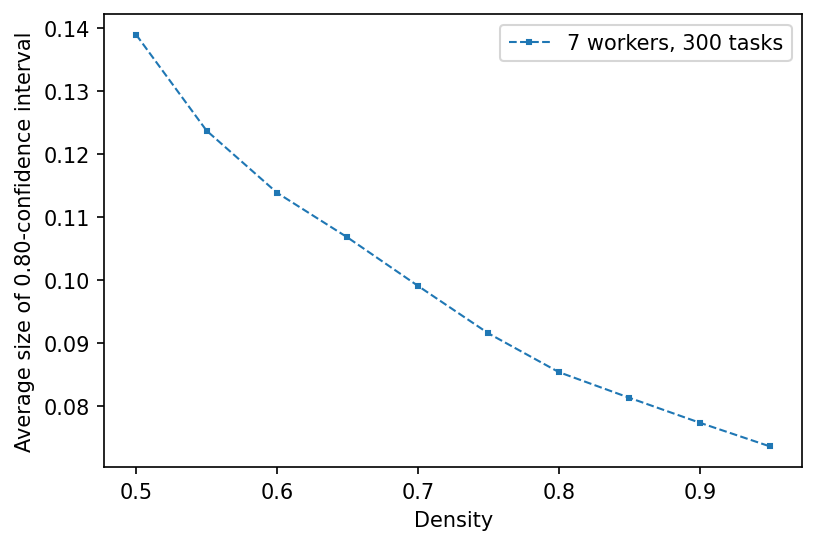

In [16]:
mpl.rcParams['figure.dpi'] = 150

plt.plot(sample_fractions, interval_sizes[(300, 7)]['new'], marker='s', linestyle='--',
             label = '7 workers, 300 tasks', linewidth=1, markersize=2)
# plt.plot(sample_fractions, interval_sizes[(300, 7)]['old greedy'], marker='s', linestyle='--',
#              label = '7 workers, 300 tasks (old)', linewidth=1, markersize=2)
# plt.plot(sample_fractions, interval_sizes[(100, 7)]['new'], marker='s', linestyle='--',
#              label = '7 workers, 100 tasks', linewidth=1, markersize=2)
plt.xlabel('Density')
plt.ylabel('Average size of ' + "{:.2f}".format(confidence_level) + '-confidence interval')
plt.legend()
plt.show()

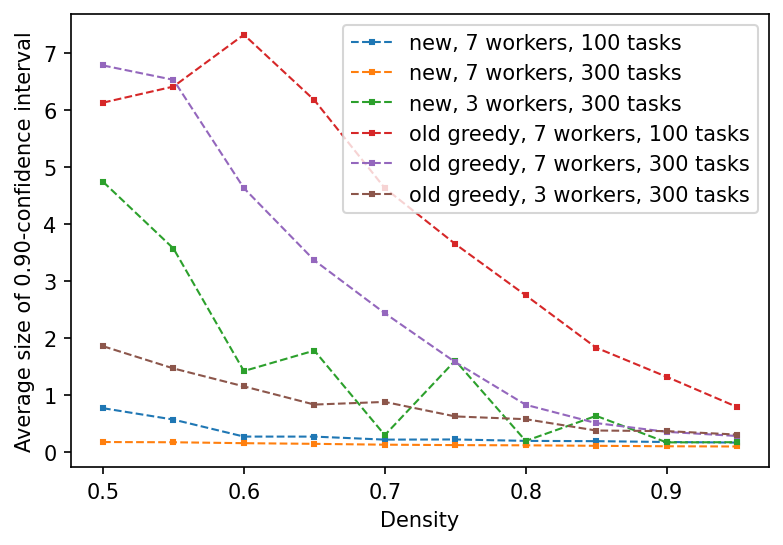

In [13]:
for t in evaluater_names:
    for m, n in configurations:
        # n: num_samples
        # m: num_workers
        plt.plot(sample_fractions, interval_sizes[(n,m)][t], marker='s', linestyle='--',
             label = t+', '+str(m)+' workers, '+str(n)+' tasks', linewidth=1, markersize=2)

plt.xlabel('Density')
plt.ylabel('Average size of ' + "{:.2f}".format(confidence_level) + '-confidence interval')
plt.legend()
plt.show()

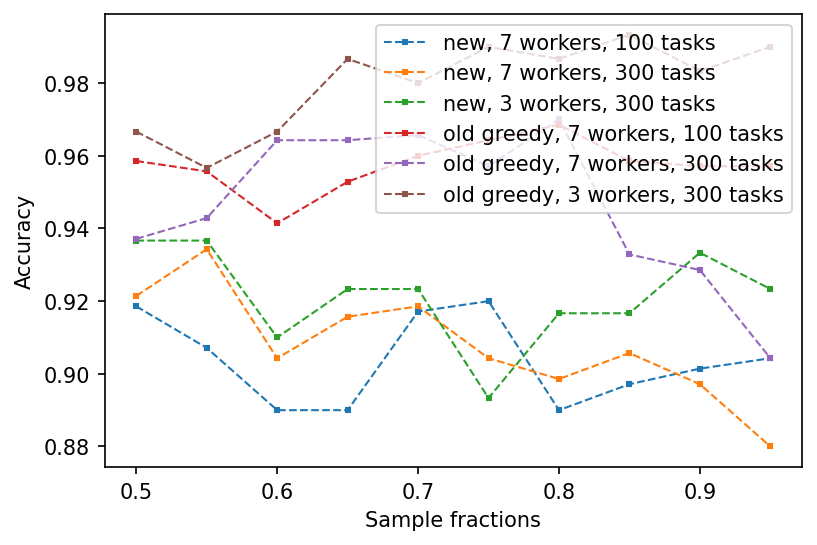

In [6]:


for t in evaluater_names:
    for m, n in configurations:
        # n: num_samples
        # m: num_workers
        plt.plot(sample_fractions, accuracies[(n,m)][t], marker='s', linestyle='--',
             label = t+', '+str(m)+' workers, '+str(n)+' tasks', linewidth=1, markersize=2)

plt.xlabel('Sample fractions')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# from visualizations.utils import visualize_error_rates
#
# p_true = np.random.choice([0.1, 0.2, 0.3], size=3)
# dataset = SyntheticDataset(
#     num_samples=100,
#     num_workers=3,
#     p_true=p_true,
#     sample_fractions=[1.0] * 3)
# evaluator = OldEvaluator(dataset)
# ps, confs = evaluator.evaluate_workers_with_confidence(
#     dataset.workers,
#     confidence=0.9,
#     method='exhaustive'
# )
#
# visualize_error_rates(
#     dataset=dataset,
#     workers=dataset.workers,
#     p_ests=[ps],
#     confs=[confs],
#     labels=['old']
# )

In [8]:
num_workers = 7
num_samples = 300
sample_fraction = 0.5
p_true = np.random.choice([0.1, 0.2, 0.3], size=num_workers)
dataset = SyntheticDataset(
    num_samples=num_samples,
    num_workers=num_workers,
    p_true=p_true,
    sample_fractions=[sample_fraction] * num_workers)
evaluator = OldEvaluator(dataset)
ps, confs = evaluator.evaluate_workers_with_confidence(
    dataset.workers,
    confidence=0.9,
    method='greedy'
)
ps, confs

(array([0.21132487, 0.        , 0.47763932, 0.47763932, 3.22678   ,
        0.        , 0.        ], dtype=float32),
 array([4.3347807, 6.091222 , 3.858049 , 3.858049 , 5.711068 , 6.091222 ,
        0.781326 ], dtype=float32))